# Classifying Leafs using Neural Nets

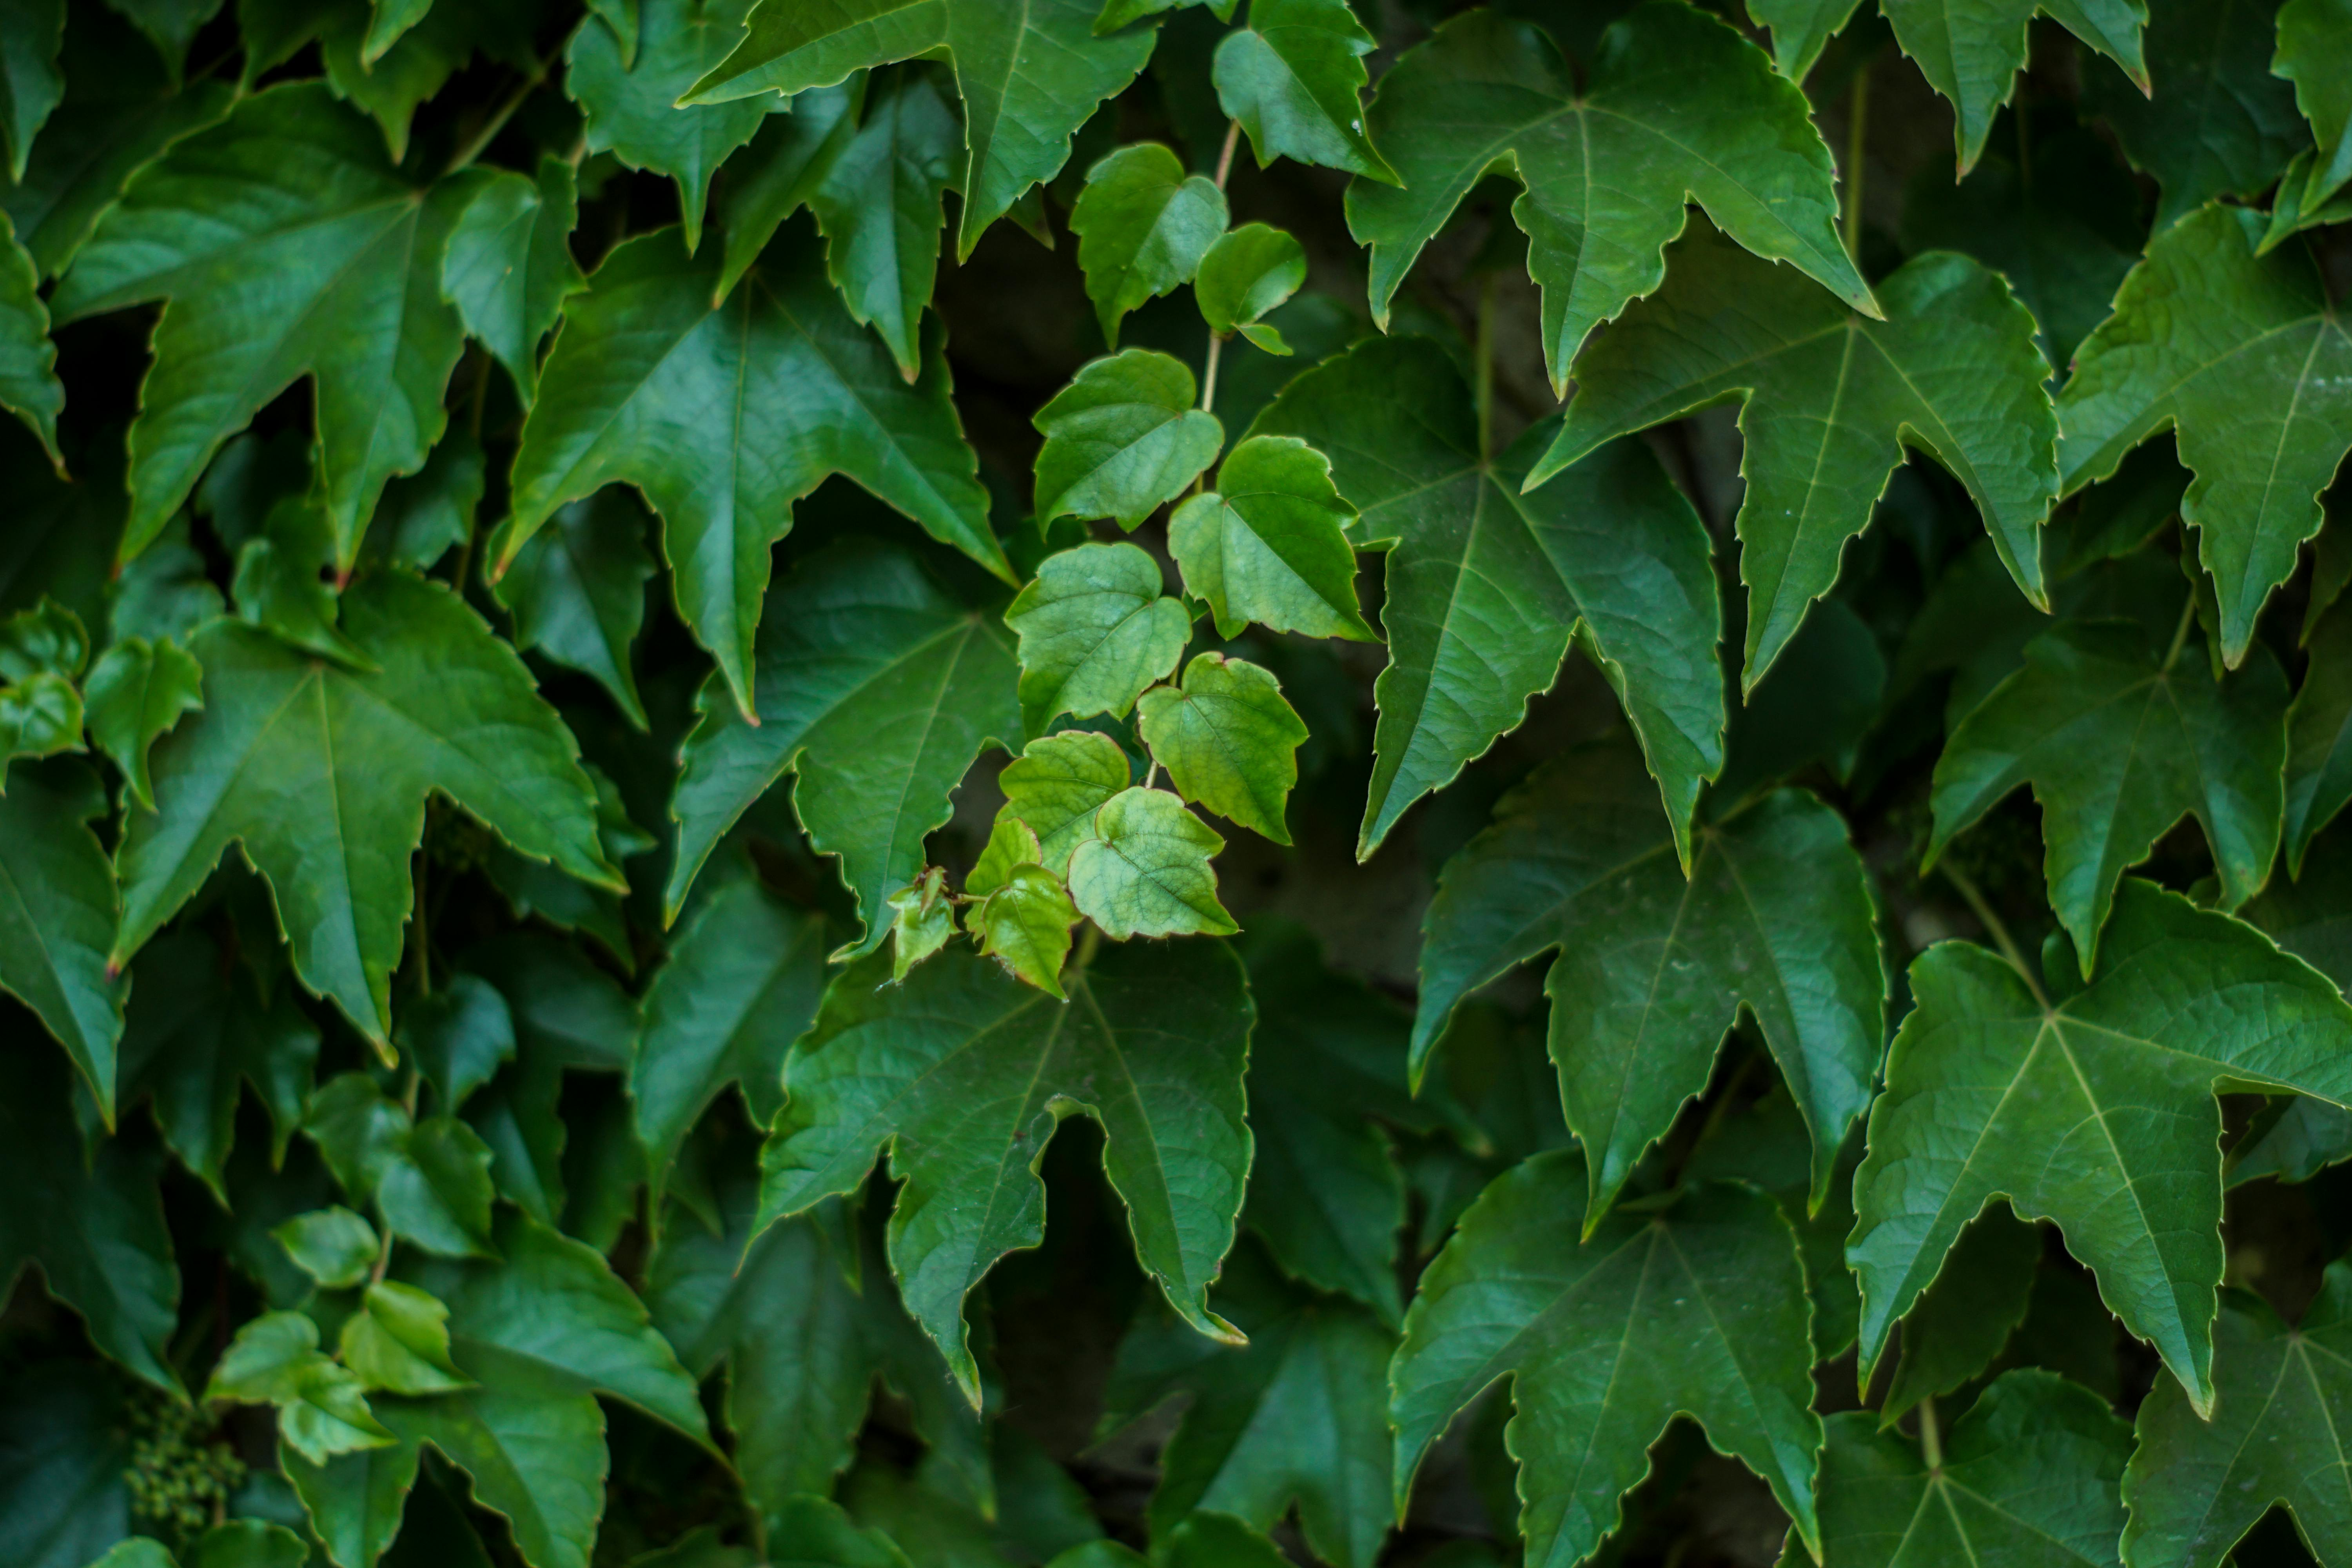

In [1]:
from IPython.display import Image
Image(filename='img/leafs.jpg', width=600, height=400)

## Intro & Approach

With an estimated 500,000 species in this world, classifying these is an historically difficult problem. Using Neural Networks, we can automate the classification with high accuracy, opening the door for many use cases in research and for businesses.


In this notebook, we are combining multiple Deep Learning approaches to train a Neural Network to classify leafs. We are using a pre-processed dataset from Kaggle (https://www.kaggle.com/competitions/leaf-classification/overview), containing black/white images of 99 different species. We are taking a look at the dataset further down.

Our model architecture consists of the following parts:

- *Convolutional Neural Networks (CNNs)* which are especially well-suited for identifying structures in images,
- *Recurrent Neural Networks (RNNs)* which are strong in identifying sequential data, and
- *Feed-Forward Neural Networks (FFNNs)* for non-sequential data as well as connection layers, bringing the different parts of the network together. 

We will discuss the network architecture further down. **But let's start with downloading/importing our necessary libraries.**

In [1]:
%%capture

# Installing necessary non-standard packages in our environment silently
! pip install pandas
! pip install scikit-image
! pip install scikit-learn
! pip install torch

# has already been downloaded and added to the repo
#! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [4]:
# Importing all necessary libraries into our notebook
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

from skimage.io import imread
from skimage.transform import resize

import data_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

## Data Import & Visualisation

We are using the pre-processed leaf dataset from a 2016 Kaggle competition. You can find the competition here: https://www.kaggle.com/competitions/leaf-classification/overview

Our data consists of 3 parts which are all to be found within our data folder:

1. **train.csv**: This table contains the data we are training our model with.
1. **test.csv**: This table contains the data we are using for model evaluation. We are never touching these during training to avoid data leakage.
3. **images/**: This folder contains the images of all leafs.

Before we start with the building/training of our Neural Net, we start by looking at the data it is supposed to learn from. 

**We start by looking into our train.csv & test.csv to understand its structure.**

In [5]:
df_train = pd.read_csv('data/train.csv')
df_train.head(5)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [6]:
# Printint some stats about our tables
image_paths = glob.glob('data/images/*.jpg') 
print("Total Observations:\t", len(image_paths))

train = pd.read_csv('data/train.csv')
train_images = ['data/images/{}.jpg'.format(i) for i in train.id.values] 

test = pd.read_csv('data/test.csv')

print(f"train.csv has the shape: {train.shape}")
print(f"test.csv has the shape: {test.shape}")

Total Observations:	 1584
train.csv has the shape: (990, 194)
test.csv has the shape: (594, 193)


<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    It looks like every row contains one leaf. We can see the ID (which maps to a xx.jpg in our <em>data/images</em> folder). Also, we can see some other data points, which, for our convenience, have already been analyzed from the images for us. We also do see the target variable "species", which we will try to predict. Analyzing the shape of our table shows us that we have a relatively small training set, with 990 rows (aka 990 leafs) to train on 99 categories. Therefore, we have 10 example for every leaf category - not much! We can also see that we have 594 examples in our test set that we can use lateron to evaluate our model. 
</div>

**Next, we'll visualise the margin, texture, and shape attributes of our table to understand their structure**

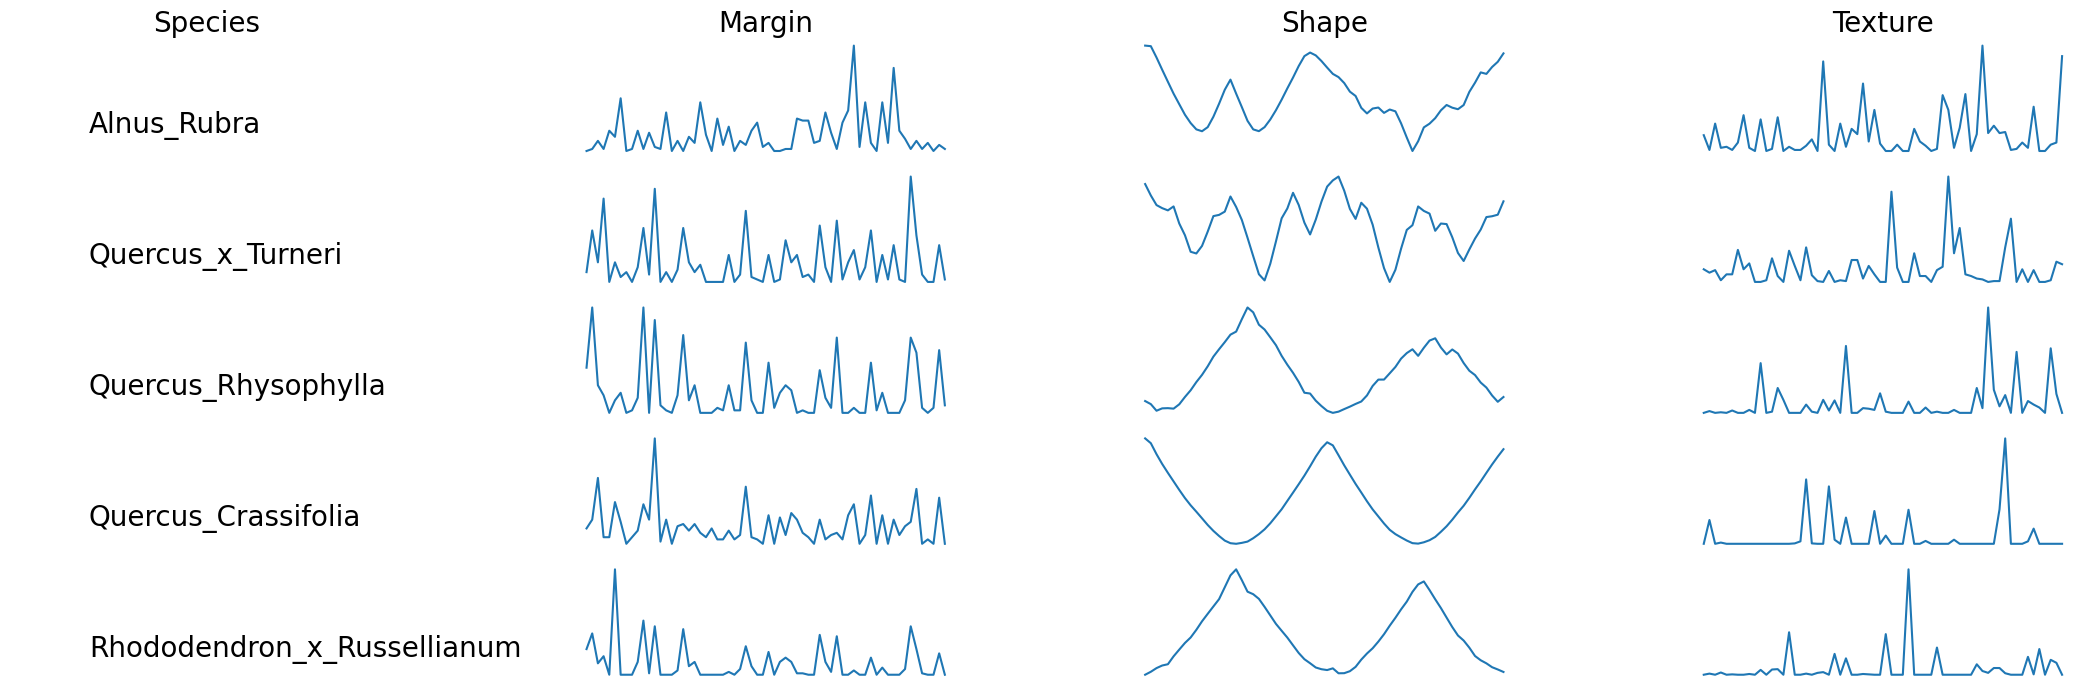

In [7]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    This visualisation is super helpful. We can see that the shape data is sequential, and outlines the shape of the leafs. We can also see the margin and texture attributes, which are non-sequential and contain further information that might be helpful by our model to detect differences in the leafs.
</div>

**Let's continue looking at some of the images in *data/images*!**

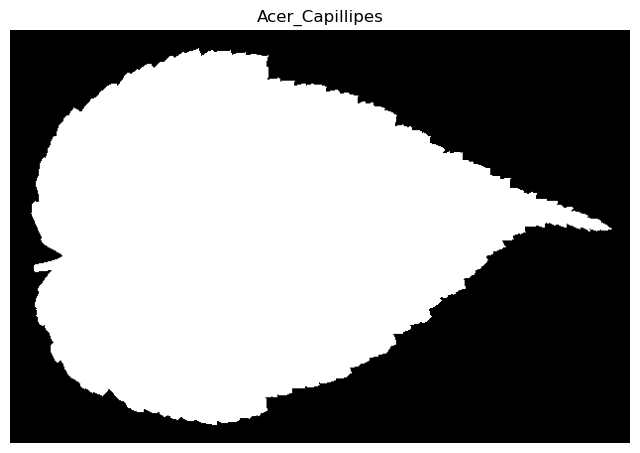

In [10]:
# First we find one example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index('data/images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

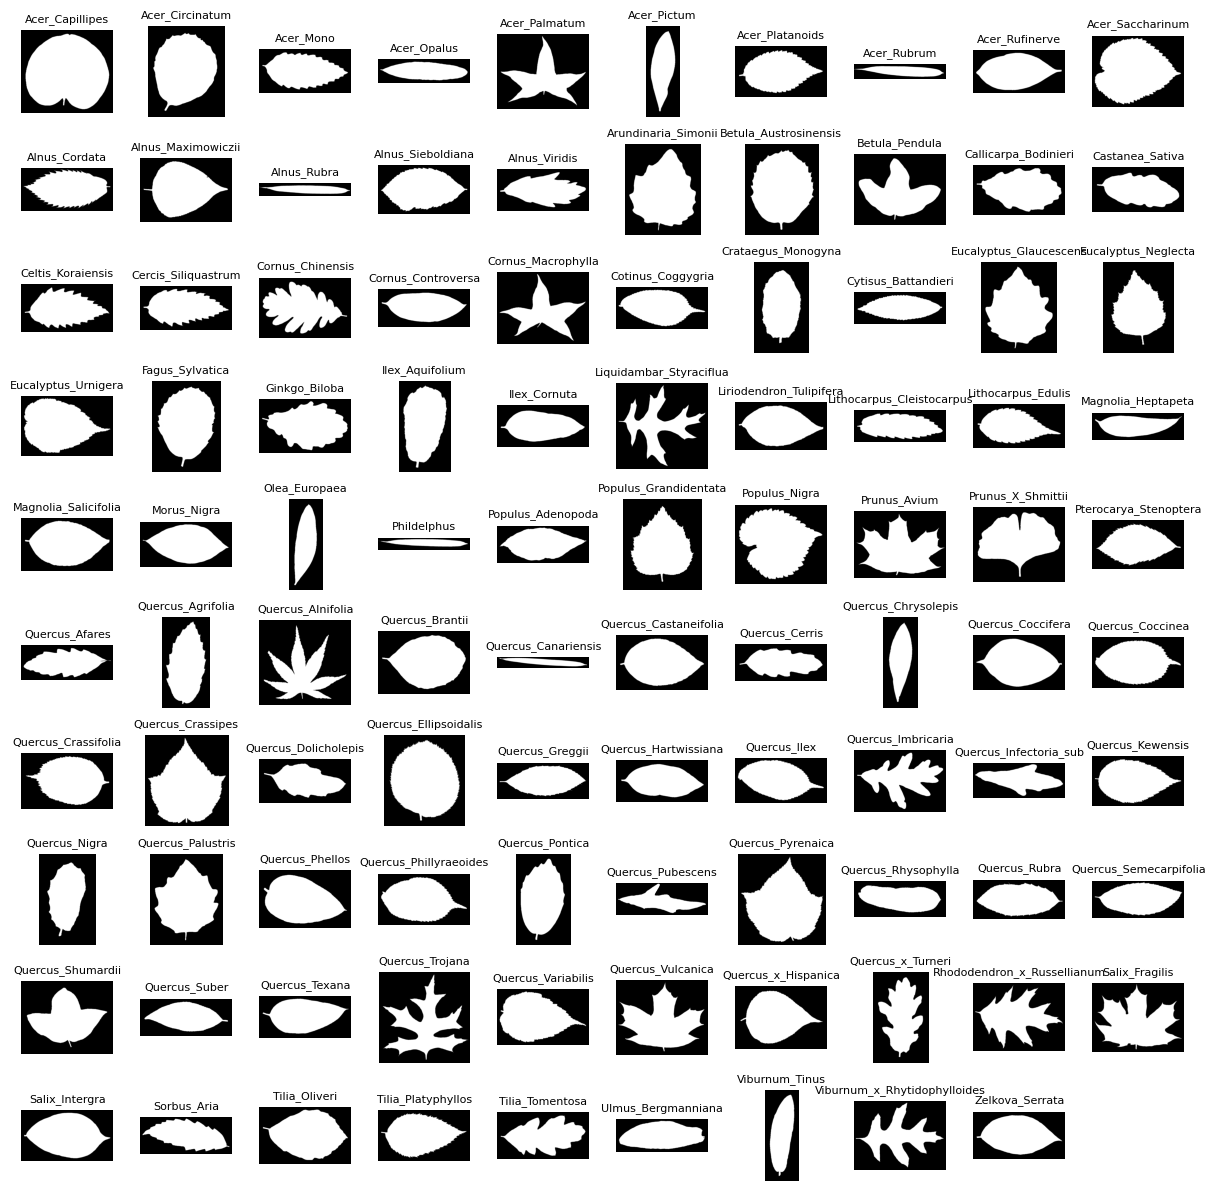

In [11]:
# Create a grid for 99 images (10x10 grid)
plt.figure(figsize=(15, 15)) 

for i in range(len(species)):
    plt.subplot(10, 10, i+1)

    image = imread(image_paths[i], as_gray=True)
    plt.imshow(image, cmap='gray')
    plt.title(species[i], fontsize=8)
    plt.axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    We can see that the images are black/white with different sizes. We can also see clear differences between the categories, which we will train our model to understand later-on
</div>

## Image Pre-Processing

As seen in our data analysis, the tables are well-formatted and are clean. However, the leafs are a bit messy, as all images have different sizes. This is problamtic for our neural network, as it will go over the different pixels and understand their meaning for classifying a leaf. If we have different sizes, we cannot easily compare the different leafs. We will therefore need to do some re-sizing to make it our model easiser. We will also generally reduce the size of the pictures, as these computations are highly expensive and training a model on these original sizes will take very long. 

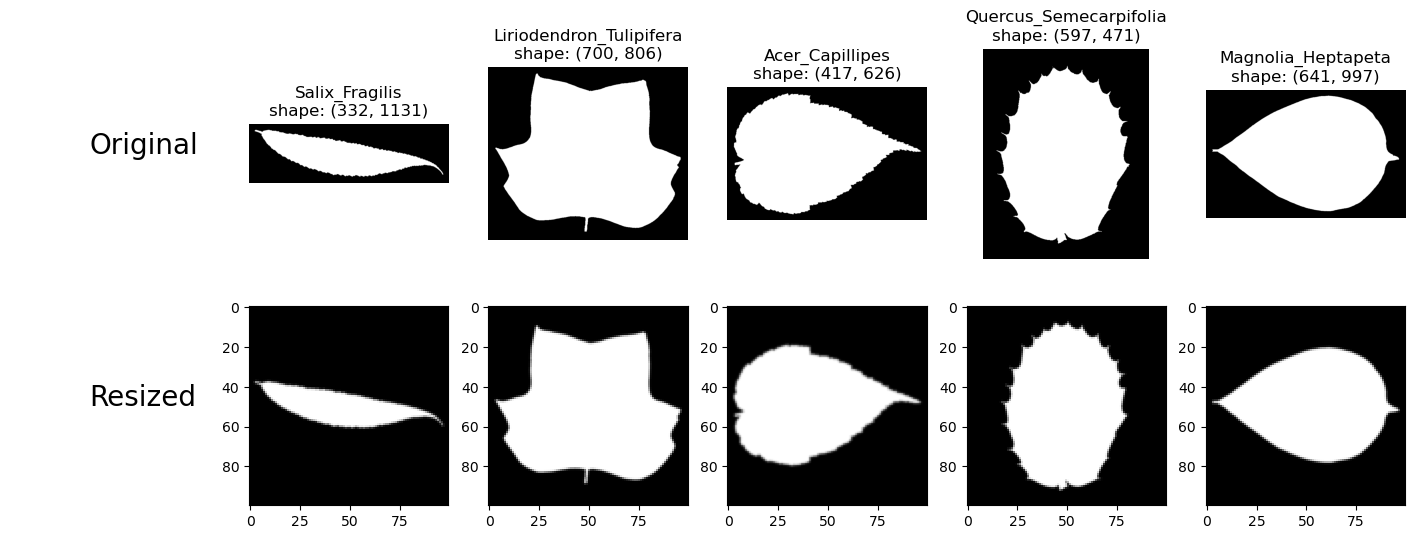

In [56]:
## Image pre-processing
image_size = (100, 100)

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')

# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    Looking good! We can see the pictures are a bit less sharp, but it is still possible to detect relevant differences. Also, all pictures have now the size 150px x 150px, which enables a uniform compution of all pixels.
</div>

## Moving all computations to GPU if available

Graphics Processing Units (GPU) significantly outperform classical CPUs for model learning. If available, we switch our computations to our GPU for improved perfomace before continuing.

In [13]:
# Checking for GPUs

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Building the model

Time to build our model! It has 4 main components:

1. CNN: The 3 convolutional layers help understanding correlations within the image that help classifying the leaf category. I have used 3 layers with each 32, 64, 256 neurons. 
2. RNN: The recurrent layers analyze the *shape* data points. RNNs are especially strong to understand sequential dependancies, as seen earlier in our shape data points. 
3. FFNN: We use 2 layers of standard Feed-Forward Neural Networks to analyze the *margin* and *texture*
4. Output Layer: We bring everything together using one final FFNN. We are using a softmax activation function (automatically detained from our loss function) to set all neurons to 0 except for the prediction, which is set to 1.

Below you'll find a sketch of the architecture model I came up with for this classification task.

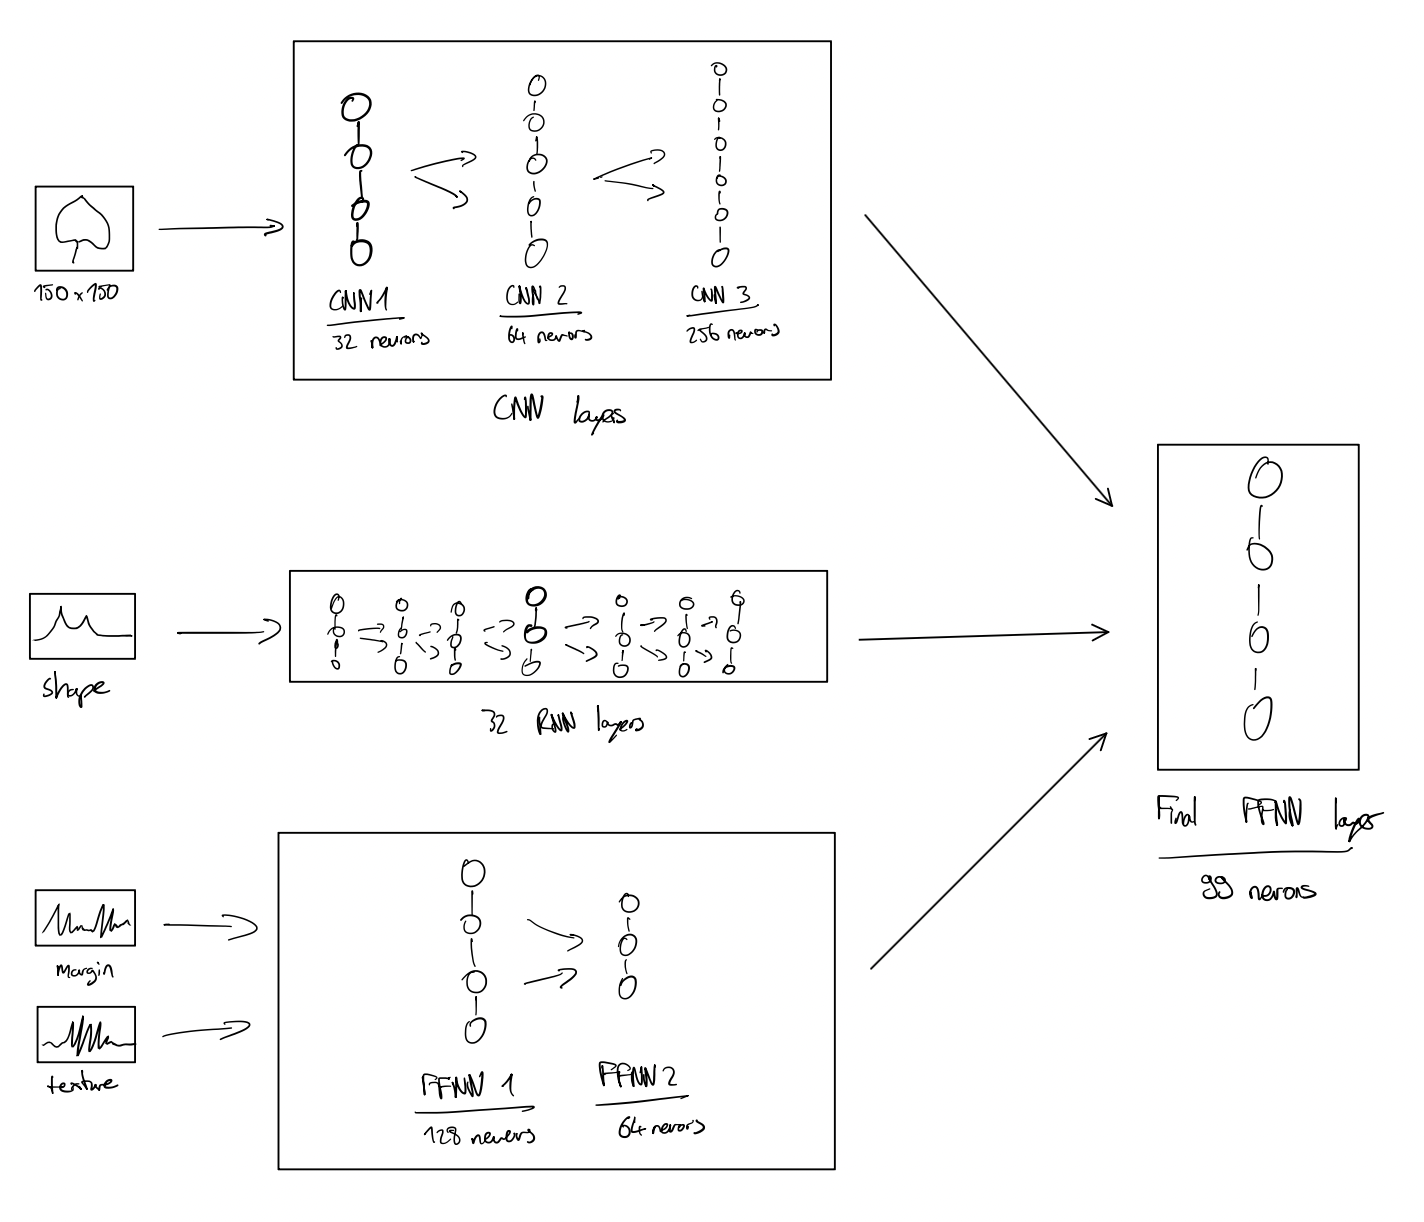

In [14]:
from IPython.display import Image
Image(filename='img/architecture.png', width=800, height=600)

**Neural Network Architecture**

In [82]:
height, width, channels = IMAGE_SHAPE

conv_out_channels1 = 32
kernel_size1 = 3
conv_stride1 = 2
conv_pad1 = 1

conv_out_channels2 = 64
kernel_size2 = 3
conv_stride2 = 2
conv_pad2 = 1

conv_out_channels3 = 256
kernel_size3 = 3
conv_stride3 = 2
conv_pad3 = 1

# Keep track of features to output layer
features_cat_size = 9312

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layer
        self.conv = nn.Sequential(
            Conv2d(in_channels=channels,
                   out_channels=conv_out_channels1,
                   kernel_size=kernel_size1,
                   stride=conv_stride1,
                   padding=conv_pad1),
            nn.BatchNorm2d(conv_out_channels1),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            Conv2d(in_channels=conv_out_channels1,
                   out_channels=conv_out_channels2,
                   kernel_size=kernel_size2,
                   stride=conv_stride2,
                   padding=conv_pad2),
            nn.BatchNorm2d(conv_out_channels2),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            Conv2d(in_channels=conv_out_channels2,
                   out_channels=conv_out_channels3,
                   kernel_size=kernel_size3,
                   stride=conv_stride3,
                   padding=conv_pad3),
            nn.BatchNorm2d(conv_out_channels3),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            MaxPool2d(kernel_size=2, stride=2),
        )

        # RNN Layer
        self.rnn_1 = nn.GRU(input_size=1,
                            hidden_size=32,
                            num_layers=3,
                            dropout=0.3,
                            batch_first=True)

        # First FFNN Layer

        self.l_1 = nn.Sequential(
            Linear(in_features = 128,
                   out_features= 128,
                   bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
        )

        # Second FFNN Layer

        self.l_2 = nn.Sequential(
            Linear(in_features = 128,
                   out_features= 64,
                   bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
        )

        # Final FFNN Layer
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)

    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}

        ## Input Image data into Convolutional layer ##
        x_img = x_img.permute(0, 3, 1, 2) # (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x_img = self.conv(x_img)
        x_img = x_img.reshape(x_img.size(0), -1) # Flatten to (batch_size, flattened_output_size)
        features.append(x_img) # Append to features vector

        ## Input shape data into GRU Layer ##
        x_shape = x_shape.unsqueeze(2)  # Reshape to (batch_size, 64, 1) for GRU input
        x_shape, _ = self.rnn_1(x_shape)
        x_shape = x_shape[:, -1, :]  # Take last hidden state from GRU (batch_size, hidden_size)
        features.append(x_shape)  # Append GRU features

        ## Input margin, texture data as tuple into features vector ##
        x = torch.cat((x_margin, x_texture), dim=1)
        x = self.l_1(x)
        x = self.l_2(x)
        features.append(x)

        ## FFNN Layers where all features are in use ##
        features_final = torch.cat(features, dim=1)
        out['out'] = self.l_out(features_final)

        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn_1): GRU(1, 32, num_layers=3, batch_first=True, dropout=0.3)
  (l_1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

## Training the model

**Loading dataset using dataloaders**

We are using a custom *load_data* function which we imported earlier via *data_utils*. This allows for computationally efficient and uniform loading and processing of our data within this jupyter notebook.

In [58]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (100,100,1)
NUM_CLASSES = 99

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 193

# Paths to data
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
IMAGE_PATHS = glob.glob("data/images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH,
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean()))
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 100, 100, 1)0.281170
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 100, 100, 1)	0.281458
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


**Creating data batches**

During training, we are not processing all data points at once. We are however also not training the model on each picture individually. Instead, we define batches. Here, 64 leafs are processed at once. The model will later classify 64 leafs at once, calculate how "wrong" it was, and then improve its model parameters.

In [59]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (64, 100, 100, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 100, 100, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 100, 100, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


**Defining the cost function**

In order to improve our model after predicting the classes for each batch, the model needs to calculate a loss against the true values. We are using the cross-entropy-loss which is recommended for multi-class classifications.

In [83]:
LEARNING_RATE = 0.01
criterion = nn.CrossEntropyLoss()

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) #added L2 regularization using weight decay

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

**Training Loop**

Now it gets interesting. We are using backpropagation to optimize our model's parameters, thus iteratively improving the classification accuracy. We are following these steps:

1. *Forward Feeding*: Starting with its initialization values, the model predicts classes for one batch of data.
2. *Loss Calculation*: The model calculates the error of its predictions against the true values.
3. *Backpropagation*: We are looking at how much every parameter (weights, biases) has contributed to the overall error by calculating the relative derivatives towards the respective parameter. This shows as in what way to change the parameter to reduce the overall error.
4. *Parameter Updates*: We are changing all parameters in the direction of their relative derivative, moving at the speed of our learning rate.

We can watch the model learning and improving its accuracy. This step will take significant time (up to 30minutes, depending on your hardware configuration)

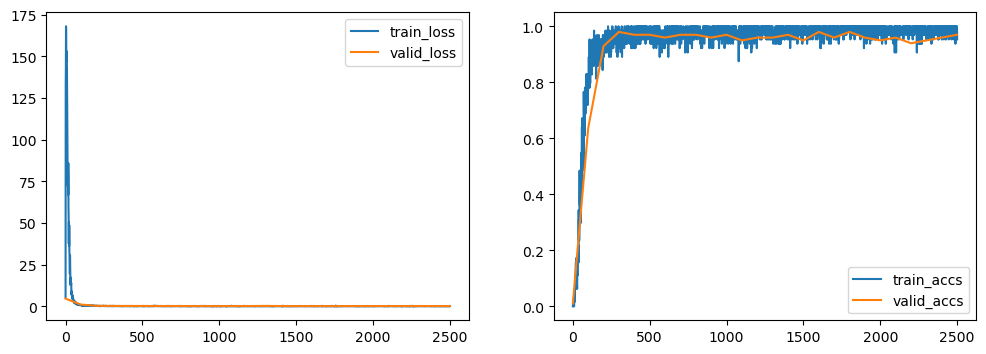

Train, Iteration 2500: Loss: 0.0949, Accuracy: 0.9531
Validation, Iteration 2500: Loss: 0.1175, Accuracy: 0.9697


In [84]:
# Setup settings for training
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 2500
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:

        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        #print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()

    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)

    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        print(f"Train, Iteration {i}: Loss: {train_loss[-1]:.4f}, Accuracy: {train_accs[-1]:.4f}")
        if valid_loss and valid_accs:  # Ensure validation lists are not empty
           print(f"Validation, Iteration {i}: Loss: {valid_loss[-1]:.4f}, Accuracy: {valid_accs[-1]:.4f}")

        clear_output(wait=True)
        #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))

    if max_iter < i:
        break

<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    The left graph shows the training and validation loss, the right graph the training and validation accuracy (which is what is truly relevant for a classification task). With both our accuracies being >0.95, we can say that our model detects more than 19/20 leafs correctly!
</div>

## Testing our model

Now that we have trained our model, let's try it out on our test data set! We'll give our model some leafs it has not seen before, and see whether it gets the classification right. 

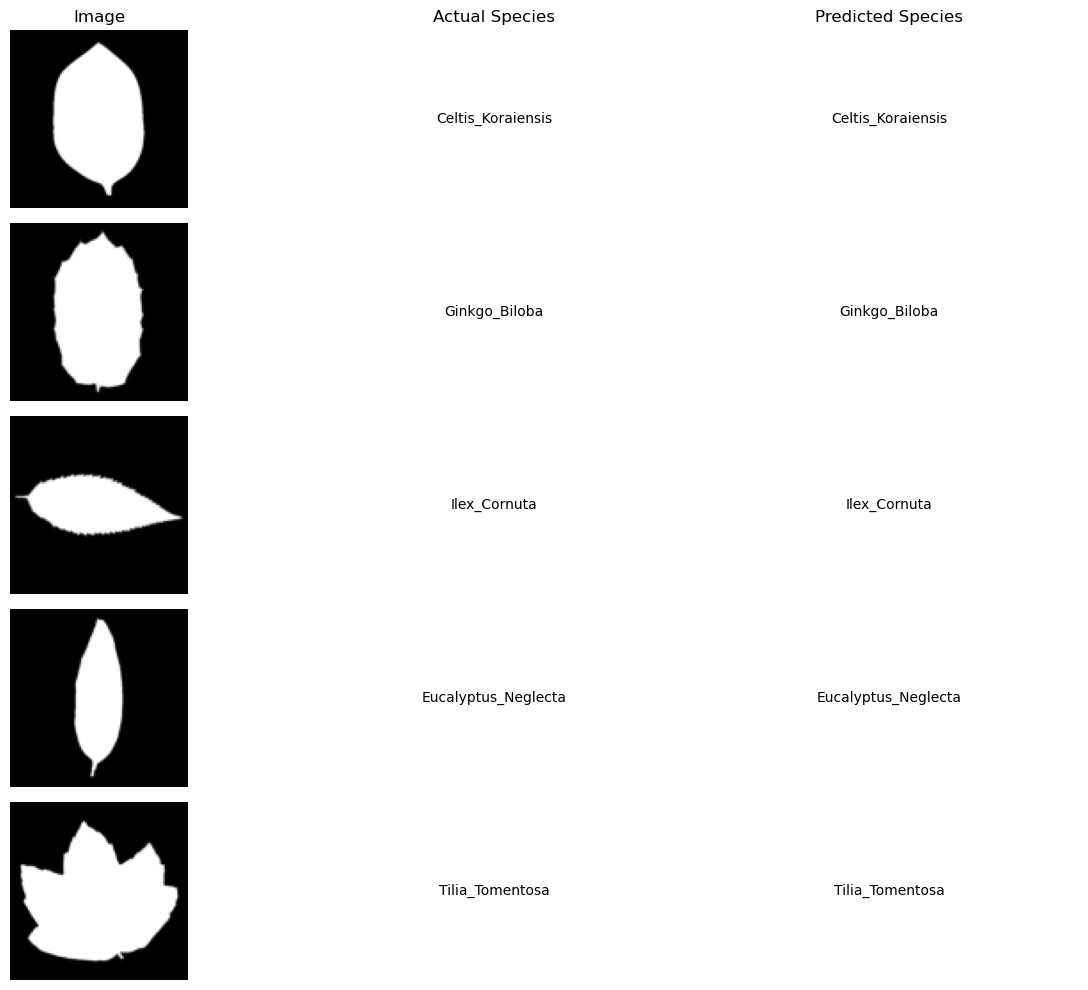

In [102]:
# Set the model to evaluation mode
net.eval()

# Use the batch generator to get a batch of 5 examples from the training data
sample_batch_gen = data_utils.batch_generator(data, batch_size=5, num_classes=NUM_CLASSES, num_iterations=1, seed=42)
sample_batch = next(sample_batch_gen.gen_train())
inputs = get_input(sample_batch)
true_labels = get_labels(sample_batch)
true_labels = torch.argmax(true_labels, dim=1)

# Make predictions
outputs = net(**inputs)['out']
predicted_labels = torch.argmax(outputs, dim=1)
species_names = train['species'].unique() 

#Plot Results
fig, axes = plt.subplots(5, 3, figsize=(12, 10)) 

for i in range(5):
    image = inputs['x_img'][i].cpu().numpy().squeeze()  
    correct_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title("Image", fontsize=12)

    axes[i, 1].text(0.5, 0.5, species_names[correct_label], ha='center', va='center', fontsize=10)
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title("Actual Species", fontsize=12)

    axes[i, 2].text(0.5, 0.5, species_names[predicted_label], ha='center', va='center', fontsize=10)
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title("Predicted Species", fontsize=12)

plt.tight_layout()
plt.show()


<div style="border: 1px solid #0b84ff; border-left: 5px solid #0b84ff; border-right: 5px solid #0b84ff; padding: 10px; background-color: #e7f3ff; border-radius: 8px; box-sizing: border-box; max-width: 100%;">
    Nice! As we can see, our model is able to predict all 5 leafs correctly!
</div>